# Задание №1. Реализация и исследование модели Хольта-Уинтерса

## 1. Реализация модели и кросс-валидации

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import pandas as pd

class HoltWinters:
    def __init__(self, alpha, beta, gamma, season_length, n_preds, seasonal):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.season_length = season_length
        self.n_preds = n_preds
        self.seasonal = seasonal

    def initialize(self, series):
        n_seasons = len(series) // self.season_length
        x = np.arange(len(series)).reshape(-1, 1)
        y = series
        reg = LinearRegression().fit(x, y)
        self.level = reg.intercept_
        self.trend = reg.coef_[0] 
        self.seasonal_factors = [np.mean(series[i::self.season_length]) - self.level for i in range(self.season_length)]

    def fit(self, series):
        self.initialize(series)
        predictions = []
        for t in range(len(series)):
            if t < self.season_length:
                predictions.append(series[t])
                continue

            last_level, last_trend = self.level, self.trend
            self.level = self.alpha * (series[t] - self.seasonal_factors[t % self.season_length]) + (1 - self.alpha) * (last_level + last_trend)
            self.trend = self.beta * (self.level - last_level) + (1 - self.beta) * last_trend
            self.seasonal_factors[t % self.season_length] = self.gamma * (series[t] - self.level) + (1 - self.gamma) * self.seasonal_factors[t % self.season_length]
            predictions.append(self.level + self.trend + self.seasonal_factors[t % self.season_length])
        self.last_level = self.level
        self.last_trend = self.trend
        self.last_season = self.seasonal_factors[-1]
        return predictions

    def predict(self):
        forecast = []
        for t in range(self.n_preds):
            forecast.append(self.level + (t+1) * self.trend + self.seasonal_factors[(t % self.season_length)])
        return forecast

def tune_holt_winters(series, season_length, param_grid):
    best_params = None
    best_error = float("inf")
    best_forecast = None
    best_predictions = None

    for params in ParameterGrid(param_grid):
        model = HoltWinters(alpha=params['alpha'], beta=params['beta'], gamma=params['gamma'], 
                            season_length=params['season_length'], n_preds=params['n_preds'], 
                            seasonal=True)
        predictions = model.fit(series)
        forecast = model.predict()
        error = mean_squared_error(series, predictions)
        if error < best_error:
            best_error = error
            best_params = params
            best_forecast = forecast
            best_predictions = predictions

    return best_params, best_forecast, best_predictions, best_error

## 2. Загрузка и предобработка данных

In [2]:
import pandas as pd

file_path = 'salary_rus.ods'
data = pd.read_excel(file_path, engine='odf')

data_long = data.melt(id_vars=['Unnamed: 0'], var_name='Месяц', value_name='Заработная плата')
data_long = data_long.rename(columns={'Unnamed: 0': 'Год'})
month_translation = {
    'Январь': 'January',
    'Февраль': 'February',
    'Март': 'March',
    'Апрель': 'April',
    'Май': 'May',
    'Июнь': 'June',
    'Июль': 'July',
    'Август': 'August',
    'Сентябрь': 'September',
    'Октябрь': 'October',
    'Ноябрь': 'November',
    'Декабрь': 'December'
}

data_long['Месяц'] = data_long['Месяц'].map(month_translation)

data_long['Дата'] = pd.to_datetime(data_long['Год'].astype(str) + '-' + data_long['Месяц'], format='%Y-%B', errors='coerce')

data_cleaned = data_long.dropna(subset=['Дата', 'Заработная плата']).sort_values(by='Дата')

data_cleaned['Заработная плата'] = pd.to_numeric(data_cleaned['Заработная плата'], errors='coerce')

data_cleaned = data_cleaned.dropna().set_index('Дата')[['Заработная плата']]

data_cleaned.head()

,Заработная плата
Дата,
1991-01-01,0.308
1991-02-01,0.294
1991-03-01,0.337
1991-04-01,0.373
1991-05-01,0.438


## 3. Построение модели и подбор гиперпараметров

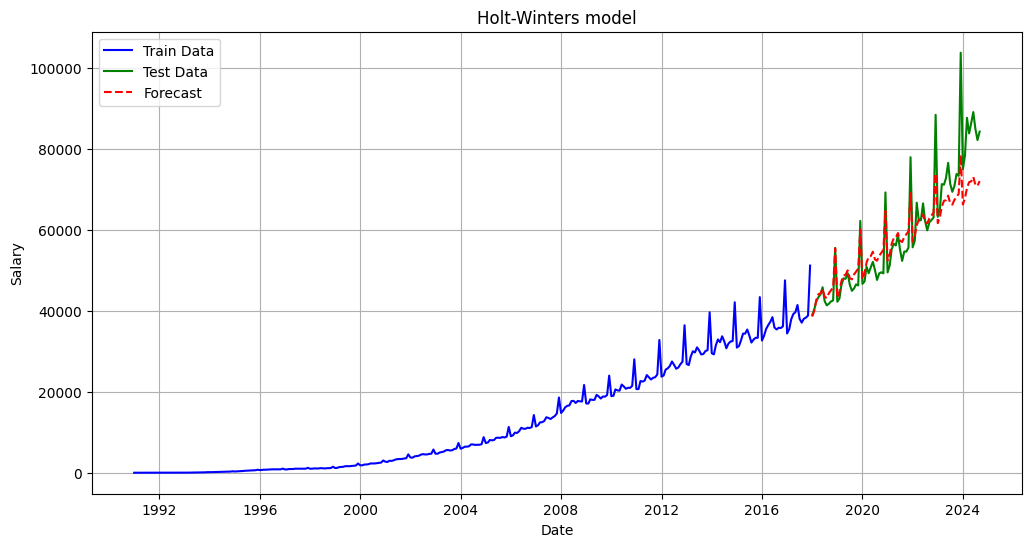

Best parameters: {'alpha': np.float64(0.7), 'beta': np.float64(0.1), 'gamma': np.float64(0.7), 'n_preds': 81, 'season_length': 12}
Last level: 51197.0
Last trend: 12274.875375450494
Last seasonal Component: 34798.36531853077
Best error: 48369.15729724823


In [3]:
import matplotlib.pyplot as plt

train_size = int(len(data_cleaned) * 0.8)
train, test = data_cleaned.iloc[:train_size], data_cleaned.iloc[train_size:]

param_grid = {
    'alpha': np.linspace(0.1, .7, 7),
    'beta': np.linspace(0.1, .7, 7),
    'gamma': np.linspace(0.1, .7, 7), 
    'season_length': [12], 
    'n_preds': [len(test)] 
}

best_params, best_forecast, best_predictions, best_error = tune_holt_winters(train['Заработная плата'].values, season_length=12, param_grid=param_grid)
forecast_index = pd.date_range(start=test.index[0], periods=len(best_forecast), freq='MS')
forecast = pd.Series(best_forecast, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Заработная плата'], label='Train Data', color='blue')
plt.plot(test.index, test['Заработная плата'], label='Test Data', color='green')
plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Holt-Winters model')
plt.xlabel('Date')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

print("Best parameters:", best_params)
print("Last level:", train['Заработная плата'].values[-1])
print("Last trend:", best_predictions[-1] - best_predictions[-2])
print("Last seasonal Component:", best_predictions[-12])
print("Best error:", best_error)


Временной ряд демонстрирует нестационарность.

Также видно, что тренд явно не линейный, а экспоненциальный. Модель ХВ предполагает использование именно с рядами, демонстрирующими линейный тренд